# **Required Packages**

In [1]:
pip install mysql-connector-python pandas requests pycountry seaborn matplotlib plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 103.7 MB/s eta 0:00:00


# **Step 1: Dataset Collection and Initial Processing**
**Nutrition Paradox Project - WHO Data Analysis**

## Public Dataset Exploration
4 public WHO API URLs  each representing a different nutritional indicator have been provided:
**For Obesity:**

https://ghoapi.azureedge.net/api/NCD_BMI_30C – Obesity among adults (BMI ≥ 30)

https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C – Obesity/Overweight among children

**For Malnutrition:**

https://ghoapi.azureedge.net/api/NCD_BMI_18C – Underweight in adults (BMI < 18.5)

https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C – Thinness in children

Each dataset provides estimates by country, sex, year, and region, along with confidence intervals (upper and lower bounds).


In [2]:
import requests
import pandas as pd
import mysql.connector
from mysql.connector import Error
import pycountry

In [3]:
# Define the API endpoints
obesity_adults_url = "https://ghoapi.azureedge.net/api/NCD_BMI_30C"
obesity_children_url = "https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C"
malnutrition_adults_url = "https://ghoapi.azureedge.net/api/NCD_BMI_18C"
malnutrition_children_url = "https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C"

## User-Defined Function

In [4]:
# Function to fetch and process data
def fetch_data(url, age_group):
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['value'])
    df['age_group'] = age_group
    return df

### New Columns to Create:
**age_group**:

Manually assign this column based on the dataset source
---

-Use "Adult" for datasets NCD_BMI_30C and NCD_BMI_18C.


---

-Use "Child/Adolescent" for datasets NCD_BMI_PLUS2C and NCD_BMI_MINUS2C.

---

In [5]:
# Fetch all datasets
df_obesity_adults = fetch_data(obesity_adults_url, "Adult")
df_obesity_children = fetch_data(obesity_children_url, "Child/Adolescent")
df_malnutrition_adults = fetch_data(malnutrition_adults_url, "Adult")
df_malnutrition_children = fetch_data(malnutrition_children_url, "Child/Adolescent")

In [6]:
# Combine obesity and malnutrition datasets
df_obesity = pd.concat([df_obesity_adults, df_obesity_children])
df_malnutrition = pd.concat([df_malnutrition_adults, df_malnutrition_children])

## Filter each dataset to include only records from the years 2012 to 2022

In [7]:
# Filter for years 2012-2022
df_obesity = df_obesity[df_obesity['TimeDim'].between(2012, 2022)]
df_malnutrition = df_malnutrition[df_malnutrition['TimeDim'].between(2012, 2022)]

In [8]:
df_obesity

,Id,IndicatorCode,SpatialDimType,SpatialDim,ParentLocationCode,TimeDimType,ParentLocation,Dim1Type,Dim1,TimeDim,...,Value,NumericValue,Low,High,Comments,Date,TimeDimensionValue,TimeDimensionBegin,TimeDimensionEnd,age_group
4,364,NCD_BMI_30C,COUNTRY,IRN,EMR,YEAR,Eastern Mediterranean,SEX,SEX_MLE,2020,...,17.5 [15.8-19.2],17.487641,15.793777,19.245727,None,2024-02-29T16:06:41.017+01:00,2020,2020-01-01T00:00:00+01:00,2020-12-31T00:00:00+01:00,Adult
11,4909,NCD_BMI_30C,COUNTRY,IRQ,EMR,YEAR,Eastern Mediterranean,SEX,SEX_MLE,2020,...,28.3 [23.1-33.8],28.335530,23.089589,33.815336,None,2024-02-29T16:06:41.017+01:00,2020,2020-01-01T00:00:00+01:00,2020-12-31T00:00:00+01:00,Adult
17,6516,NCD_BMI_30C,COUNTRY,GRL,EUR,YEAR,Europe,SEX,SEX_FMLE,2014,...,27.9 [24.9-31.2],27.948704,24.924766,31.213260,None,2024-02-29T16:06:41.017+01:00,2014,2014-01-01T00:00:00+01:00,2014-12-31T00:00:00+01:00,Adult
19,7785,NCD_BMI_30C,COUNTRY,ARM,EUR,YEAR,Europe,SEX,SEX_FMLE,2019,...,31.9 [28.2-35.6],31.893221,28.160682,35.574925,None,2024-02-29T16:06:41.017+01:00,2019,2019-01-01T00:00:00+01:00,2019-12-31T00:00:00+01:00,Adult
20,8855,NCD_BMI_30C,COUNTRY,MLT,EUR,YEAR,Europe,SEX,SEX_BTSX,2018,...,33.7 [29.9-37.5],33.694205,29.905805,37.470856,None,2024-02-29T16:06:41.017+01:00,2018,2018-01-01T00:00:00+01:00,2018-12-31T00:00:00+01:00,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62347,10114473,NCD_BMI_PLUS2C,COUNTRY,TJK,EUR,YEAR,Europe,SEX,SEX_BTSX,2020,...,1.5 [1.0-2.2],1.475931,0.964176,2.197432,None,2024-02-29T16:06:41.017+01:00,2020,2020-01-01T00:00:00+01:00,2020-12-31T00:00:00+01:00,Child/Adolescent
62350,10115376,NCD_BMI_PLUS2C,COUNTRY,SOM,EMR,YEAR,Eastern Mediterranean,SEX,SEX_FMLE,2012,...,2.0 [0.3-5.9],1.966190,0.302039,5.872414,None,2024-02-29T16:06:41.017+01:00,2012,2012-01-01T00:00:00+01:00,2012-12-31T00:00:00+01:00,Child/Adolescent
62358,10116897,NCD_BMI_PLUS2C,COUNTRY,VUT,WPR,YEAR,Western Pacific,SEX,SEX_MLE,2021,...,16.6 [3.3-34.9],16.634887,3.325899,34.877816,None,2024-02-29T16:06:41.017+01:00,2021,2021-01-01T00:00:00+01:00,2021-12-31T00:00:00+01:00,Child/Adolescent
62361,10117364,NCD_BMI_PLUS2C,COUNTRY,MDG,AFR,YEAR,Africa,SEX,SEX_MLE,2014,...,2.0 [0.2-6.3],2.032189,0.236481,6.341185,None,2024-02-29T16:06:41.017+01:00,2014,2014-01-01T00:00:00+01:00,2014-12-31T00:00:00+01:00,Child/Adolescent


In [9]:
df_malnutrition

,Id,IndicatorCode,SpatialDimType,SpatialDim,ParentLocationCode,TimeDimType,ParentLocation,Dim1Type,Dim1,TimeDim,...,Value,NumericValue,Low,High,Comments,Date,TimeDimensionValue,TimeDimensionBegin,TimeDimensionEnd,age_group
0,7639674,NCD_BMI_18C,COUNTRY,LBR,AFR,YEAR,Africa,SEX,SEX_BTSX,2019,...,6.1 [5.0-7.5],6.147330,4.974405,7.479860,None,2024-02-29T16:06:41.017+01:00,2019,2019-01-01T00:00:00+01:00,2019-12-31T00:00:00+01:00,Adult
1,7639779,NCD_BMI_18C,COUNTRY,SYR,EMR,YEAR,Eastern Mediterranean,SEX,SEX_BTSX,2013,...,3.0 [1.8-4.7],3.042609,1.770855,4.654348,None,2024-02-29T16:06:41.017+01:00,2013,2013-01-01T00:00:00+01:00,2013-12-31T00:00:00+01:00,Adult
3,54,NCD_BMI_18C,COUNTRY,GAB,AFR,YEAR,Africa,SEX,SEX_FMLE,2021,...,5.8 [4.0-8.1],5.795110,3.972036,8.077021,None,2024-02-29T16:06:41.017+01:00,2021,2021-01-01T00:00:00+01:00,2021-12-31T00:00:00+01:00,Adult
7,2272,NCD_BMI_18C,COUNTRY,MNG,WPR,YEAR,Western Pacific,SEX,SEX_BTSX,2017,...,3.1 [2.4-3.8],3.090652,2.428230,3.842155,None,2024-02-29T16:06:41.017+01:00,2017,2017-01-01T00:00:00+01:00,2017-12-31T00:00:00+01:00,Adult
8,2584,NCD_BMI_18C,COUNTRY,SLE,AFR,YEAR,Africa,SEX,SEX_FMLE,2016,...,8.4 [6.7-10.3],8.371724,6.655668,10.253121,None,2024-02-29T16:06:41.017+01:00,2016,2016-01-01T00:00:00+01:00,2016-12-31T00:00:00+01:00,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62357,10115264,NCD_BMI_MINUS2C,COUNTRY,HTI,AMR,YEAR,Americas,SEX,SEX_FMLE,2013,...,4.1 [2.8-5.7],4.140693,2.795499,5.714345,None,2024-02-29T16:06:41.017+01:00,2013,2013-01-01T00:00:00+01:00,2013-12-31T00:00:00+01:00,Child/Adolescent
62359,10116273,NCD_BMI_MINUS2C,COUNTRY,TJK,EUR,YEAR,Europe,SEX,SEX_BTSX,2018,...,7.6 [5.4-10.2],7.574986,5.428173,10.218395,None,2024-02-29T16:06:41.017+01:00,2018,2018-01-01T00:00:00+01:00,2018-12-31T00:00:00+01:00,Child/Adolescent
62360,10116414,NCD_BMI_MINUS2C,COUNTRY,PNG,WPR,YEAR,Western Pacific,SEX,SEX_BTSX,2016,...,1.7 [0.6-3.5],1.703645,0.621721,3.507061,None,2024-02-29T16:06:41.017+01:00,2016,2016-01-01T00:00:00+01:00,2016-12-31T00:00:00+01:00,Child/Adolescent
62366,10117545,NCD_BMI_MINUS2C,COUNTRY,WSM,WPR,YEAR,Western Pacific,SEX,SEX_FMLE,2020,...,0.7 [0.1-2.8],0.734066,0.064152,2.810176,None,2024-02-29T16:06:41.017+01:00,2020,2020-01-01T00:00:00+01:00,2020-12-31T00:00:00+01:00,Child/Adolescent


# **Step 2: Data Cleaning and Feature Engineering**

## Define columns to retain and rename

In [10]:
columns_to_keep = {
    'ParentLocation': 'Region',
    'Dim1': 'Gender',
    'TimeDim': 'Year',
    'Low': 'LowerBound',
    'High': 'UpperBound',
    'NumericValue': 'Mean_Estimate',
    'SpatialDim': 'Country',
    'age_group': 'age_group'
}

In [11]:
df_obesity.columns

Index(['Id', 'IndicatorCode', 'SpatialDimType', 'SpatialDim',
       'ParentLocationCode', 'TimeDimType', 'ParentLocation', 'Dim1Type',
       'Dim1', 'TimeDim', 'Dim2Type', 'Dim2', 'Dim3Type', 'Dim3',
       'DataSourceDimType', 'DataSourceDim', 'Value', 'NumericValue', 'Low',
       'High', 'Comments', 'Date', 'TimeDimensionValue', 'TimeDimensionBegin',
       'TimeDimensionEnd', 'age_group'],
      dtype='object')

In [12]:
df_malnutrition.columns

Index(['Id', 'IndicatorCode', 'SpatialDimType', 'SpatialDim',
       'ParentLocationCode', 'TimeDimType', 'ParentLocation', 'Dim1Type',
       'Dim1', 'TimeDim', 'Dim2Type', 'Dim2', 'Dim3Type', 'Dim3',
       'DataSourceDimType', 'DataSourceDim', 'Value', 'NumericValue', 'Low',
       'High', 'Comments', 'Date', 'TimeDimensionValue', 'TimeDimensionBegin',
       'TimeDimensionEnd', 'age_group'],
      dtype='object')

In [13]:
# Apply column selection and renaming
df_obesity = df_obesity[columns_to_keep.keys()].rename(columns=columns_to_keep)
df_malnutrition = df_malnutrition[columns_to_keep.keys()].rename(columns=columns_to_keep)

In [14]:
df_obesity

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group
4,Eastern Mediterranean,SEX_MLE,2020,15.793777,19.245727,17.487641,IRN,Adult
11,Eastern Mediterranean,SEX_MLE,2020,23.089589,33.815336,28.335530,IRQ,Adult
17,Europe,SEX_FMLE,2014,24.924766,31.213260,27.948704,GRL,Adult
19,Europe,SEX_FMLE,2019,28.160682,35.574925,31.893221,ARM,Adult
20,Europe,SEX_BTSX,2018,29.905805,37.470856,33.694205,MLT,Adult
...,...,...,...,...,...,...,...,...
62347,Europe,SEX_BTSX,2020,0.964176,2.197432,1.475931,TJK,Child/Adolescent
62350,Eastern Mediterranean,SEX_FMLE,2012,0.302039,5.872414,1.966190,SOM,Child/Adolescent
62358,Western Pacific,SEX_MLE,2021,3.325899,34.877816,16.634887,VUT,Child/Adolescent
62361,Africa,SEX_MLE,2014,0.236481,6.341185,2.032189,MDG,Child/Adolescent


In [15]:
df_malnutrition

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group
0,Africa,SEX_BTSX,2019,4.974405,7.479860,6.147330,LBR,Adult
1,Eastern Mediterranean,SEX_BTSX,2013,1.770855,4.654348,3.042609,SYR,Adult
3,Africa,SEX_FMLE,2021,3.972036,8.077021,5.795110,GAB,Adult
7,Western Pacific,SEX_BTSX,2017,2.428230,3.842155,3.090652,MNG,Adult
8,Africa,SEX_FMLE,2016,6.655668,10.253121,8.371724,SLE,Adult
...,...,...,...,...,...,...,...,...
62357,Americas,SEX_FMLE,2013,2.795499,5.714345,4.140693,HTI,Child/Adolescent
62359,Europe,SEX_BTSX,2018,5.428173,10.218395,7.574986,TJK,Child/Adolescent
62360,Western Pacific,SEX_BTSX,2016,0.621721,3.507061,1.703645,PNG,Child/Adolescent
62366,Western Pacific,SEX_FMLE,2020,0.064152,2.810176,0.734066,WSM,Child/Adolescent


## Country Column

In [17]:
# Handle special country cases
special_cases = {
    'GLOBAL': 'Global',
    'WB_LMI': 'Low & Middle Income',
    'WB_HI': 'High Income',
    'WB_LI': 'Low Income',
    'EMR': 'Eastern Mediterranean Region',
    'EUR': 'Europe',
    'AFR': 'Africa',
    'SEAR': 'South-East Asia Region',
    'WPR': 'Western Pacific Region',
    'AMR': 'Americas Region',
    'WB_UMI': 'Upper Middle Income'
}

In [18]:
def convert_country_code(code):
    # Converts country codes to full country names or special region names
    if code in special_cases:
        return special_cases[code]
    try:
        return pycountry.countries.get(alpha_3=code).name
    except:
        return code

In [19]:
# Apply country code conversion
df_obesity['Country'] = df_obesity['Country'].apply(convert_country_code)
df_malnutrition['Country'] = df_malnutrition['Country'].apply(convert_country_code)

In [20]:
df_obesity

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group
4,Eastern Mediterranean,SEX_MLE,2020,15.793777,19.245727,17.487641,"Iran, Islamic Republic of",Adult
11,Eastern Mediterranean,SEX_MLE,2020,23.089589,33.815336,28.335530,Iraq,Adult
17,Europe,SEX_FMLE,2014,24.924766,31.213260,27.948704,Greenland,Adult
19,Europe,SEX_FMLE,2019,28.160682,35.574925,31.893221,Armenia,Adult
20,Europe,SEX_BTSX,2018,29.905805,37.470856,33.694205,Malta,Adult
...,...,...,...,...,...,...,...,...
62347,Europe,SEX_BTSX,2020,0.964176,2.197432,1.475931,Tajikistan,Child/Adolescent
62350,Eastern Mediterranean,SEX_FMLE,2012,0.302039,5.872414,1.966190,Somalia,Child/Adolescent
62358,Western Pacific,SEX_MLE,2021,3.325899,34.877816,16.634887,Vanuatu,Child/Adolescent
62361,Africa,SEX_MLE,2014,0.236481,6.341185,2.032189,Madagascar,Child/Adolescent


## Standardize Gender values

In [22]:
df_obesity['Gender'].unique()

array(['SEX_MLE', 'SEX_FMLE', 'SEX_BTSX'], dtype=object)

In [23]:
gender_mapping = {'SEX_MLE': 'Male',
                  'SEX_FMLE': 'Female',
                  'SEX_BTSX': 'Both',
                  }

In [24]:
# df_obesity['Gender'] = df_obesity['Gender'].replace{'SEX_MLE': 'Male',
#                   'SEX_FMLE': 'Female',
#                   'SEX_BTSX': 'Both',
#                   }

In [25]:
df_obesity['Gender'] = df_obesity['Gender'].map(gender_mapping)
print(f"Gender values: {df_obesity['Gender'].unique()}")

Gender values: ['Male' 'Female' 'Both']


In [26]:
df_malnutrition['Gender'] = df_malnutrition['Gender'].map(gender_mapping)
print(f"Gender values: {df_malnutrition['Gender'].unique()}")

Gender values: ['Both' 'Female' 'Male']


## New Columns to Create:

**CI_Width**:

Calculate the confidence interval width.
Formula: CI_Width = High - Low

**obesity_level (for the obesity table only):**


**Categorize obesity levels based on NumericValue:**

>= 30 → High

25–29.9 → Moderate

< 25 → Low


**malnutrition_level (for the malnutrition table only):**

**Categorize malnutrition levels based on NumericValue:**

>= 20 → High

10–19.9 → Moderate

< 10 → Low

In [27]:
# Create new features
df_obesity['CI_Width'] = df_obesity['UpperBound'] - df_obesity['LowerBound']
df_malnutrition['CI_Width'] = df_malnutrition['UpperBound'] - df_malnutrition['LowerBound']

In [28]:
df_obesity

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width
4,Eastern Mediterranean,Male,2020,15.793777,19.245727,17.487641,"Iran, Islamic Republic of",Adult,3.451950
11,Eastern Mediterranean,Male,2020,23.089589,33.815336,28.335530,Iraq,Adult,10.725747
17,Europe,Female,2014,24.924766,31.213260,27.948704,Greenland,Adult,6.288494
19,Europe,Female,2019,28.160682,35.574925,31.893221,Armenia,Adult,7.414243
20,Europe,Both,2018,29.905805,37.470856,33.694205,Malta,Adult,7.565051
...,...,...,...,...,...,...,...,...,...
62347,Europe,Both,2020,0.964176,2.197432,1.475931,Tajikistan,Child/Adolescent,1.233255
62350,Eastern Mediterranean,Female,2012,0.302039,5.872414,1.966190,Somalia,Child/Adolescent,5.570375
62358,Western Pacific,Male,2021,3.325899,34.877816,16.634887,Vanuatu,Child/Adolescent,31.551917
62361,Africa,Male,2014,0.236481,6.341185,2.032189,Madagascar,Child/Adolescent,6.104704


In [29]:
df_malnutrition

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width
0,Africa,Both,2019,4.974405,7.479860,6.147330,Liberia,Adult,2.505455
1,Eastern Mediterranean,Both,2013,1.770855,4.654348,3.042609,Syrian Arab Republic,Adult,2.883493
3,Africa,Female,2021,3.972036,8.077021,5.795110,Gabon,Adult,4.104985
7,Western Pacific,Both,2017,2.428230,3.842155,3.090652,Mongolia,Adult,1.413925
8,Africa,Female,2016,6.655668,10.253121,8.371724,Sierra Leone,Adult,3.597453
...,...,...,...,...,...,...,...,...,...
62357,Americas,Female,2013,2.795499,5.714345,4.140693,Haiti,Child/Adolescent,2.918846
62359,Europe,Both,2018,5.428173,10.218395,7.574986,Tajikistan,Child/Adolescent,4.790222
62360,Western Pacific,Both,2016,0.621721,3.507061,1.703645,Papua New Guinea,Child/Adolescent,2.885340
62366,Western Pacific,Female,2020,0.064152,2.810176,0.734066,Samoa,Child/Adolescent,2.746023


## **Obesity_level & Malnutrition_level**

In [35]:
def categorize_obesity(value):
    if value >= 30:
        return 'High'
    elif value >= 25:
        return 'Moderate'
    else:
        return 'Low'

In [34]:
def categorize_malnutrition(value):
    if value >= 20:
        return 'High'
    elif value >= 10:
        return 'Moderate'
    else:
        return 'Low'

In [36]:
df_obesity['obesity_level'] = df_obesity['Mean_Estimate'].apply(categorize_obesity)
df_malnutrition['malnutrition_level'] = df_malnutrition['Mean_Estimate'].apply(categorize_malnutrition)

In [37]:
df_obesity

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,obesity_level
4,Eastern Mediterranean,Male,2020,15.793777,19.245727,17.487641,"Iran, Islamic Republic of",Adult,3.451950,Low
11,Eastern Mediterranean,Male,2020,23.089589,33.815336,28.335530,Iraq,Adult,10.725747,Moderate
17,Europe,Female,2014,24.924766,31.213260,27.948704,Greenland,Adult,6.288494,Moderate
19,Europe,Female,2019,28.160682,35.574925,31.893221,Armenia,Adult,7.414243,High
20,Europe,Both,2018,29.905805,37.470856,33.694205,Malta,Adult,7.565051,High
...,...,...,...,...,...,...,...,...,...,...
62347,Europe,Both,2020,0.964176,2.197432,1.475931,Tajikistan,Child/Adolescent,1.233255,Low
62350,Eastern Mediterranean,Female,2012,0.302039,5.872414,1.966190,Somalia,Child/Adolescent,5.570375,Low
62358,Western Pacific,Male,2021,3.325899,34.877816,16.634887,Vanuatu,Child/Adolescent,31.551917,Low
62361,Africa,Male,2014,0.236481,6.341185,2.032189,Madagascar,Child/Adolescent,6.104704,Low


In [38]:
df_malnutrition

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,malnutrition_level
0,Africa,Both,2019,4.974405,7.479860,6.147330,Liberia,Adult,2.505455,Low
1,Eastern Mediterranean,Both,2013,1.770855,4.654348,3.042609,Syrian Arab Republic,Adult,2.883493,Low
3,Africa,Female,2021,3.972036,8.077021,5.795110,Gabon,Adult,4.104985,Low
7,Western Pacific,Both,2017,2.428230,3.842155,3.090652,Mongolia,Adult,1.413925,Low
8,Africa,Female,2016,6.655668,10.253121,8.371724,Sierra Leone,Adult,3.597453,Low
...,...,...,...,...,...,...,...,...,...,...
62357,Americas,Female,2013,2.795499,5.714345,4.140693,Haiti,Child/Adolescent,2.918846,Low
62359,Europe,Both,2018,5.428173,10.218395,7.574986,Tajikistan,Child/Adolescent,4.790222,Low
62360,Western Pacific,Both,2016,0.621721,3.507061,1.703645,Papua New Guinea,Child/Adolescent,2.885340,Low
62366,Western Pacific,Female,2020,0.064152,2.810176,0.734066,Samoa,Child/Adolescent,2.746023,Low


## Missing values check

In [39]:
print("\nMissing Values in Obesity Data:")
print(df_obesity.isnull().sum())


Missing Values in Obesity Data:
Region           1452
Gender              0
Year                0
LowerBound          0
UpperBound          0
Mean_Estimate       0
Country             0
age_group           0
CI_Width            0
obesity_level       0
dtype: int64


In [40]:
print("\nMissing Values in Malnutrition Data:")
print(df_malnutrition.isnull().sum())


Missing Values in Malnutrition Data:
Region                1452
Gender                   0
Year                     0
LowerBound               0
UpperBound               0
Mean_Estimate            0
Country                  0
age_group                0
CI_Width                 0
malnutrition_level       0
dtype: int64


In [ ]:
df_obesity['Region'].unique()

array(['Eastern Mediterranean', 'Europe', 'Americas', 'South-East Asia',
       'Africa', 'Western Pacific', None], dtype=object)

In [ ]:
df_malnutrition['Region'].unique()

array(['Africa', 'Western Pacific', None, 'Eastern Mediterranean',
       'Europe', 'Americas', 'South-East Asia'], dtype=object)

## Missing Values
```
#special_cases = {
    'GLOBAL': 'Global',
    'WB_LMI': 'Low & Middle Income',
    'WB_HI': 'High Income',
    'WB_LI': 'Low Income',
    'EMR': 'Eastern Mediterranean Region',
    'EUR': 'Europe',
    'AFR': 'Africa',
    'SEAR': 'South-East Asia Region',
    'WPR': 'Western Pacific Region',
    'AMR': 'Americas Region',
    'WB_UMI': 'Upper Middle Income'
}
```



In [41]:
df_malnutrition[df_malnutrition['Country']=='Global']

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,malnutrition_level
2542,None,Male,2019,6.920451,7.824215,7.369630,Global,Adult,0.903764,Low
2723,None,Female,2016,8.645694,9.234868,8.944437,Global,Adult,0.589174,Low
3739,None,Male,2022,6.116152,7.402007,6.738611,Global,Adult,1.285855,Low
4203,None,Female,2015,8.935650,9.500933,9.222165,Global,Adult,0.565283,Low
4256,None,Male,2014,8.300319,8.980735,8.640486,Global,Adult,0.680416,Low
...,...,...,...,...,...,...,...,...,...,...
58403,None,Male,2013,10.283919,11.492490,10.871921,Global,Child/Adolescent,1.208571,Moderate
58618,None,Female,2013,8.659063,9.449733,9.051900,Global,Child/Adolescent,0.790670,Low
59511,None,Both,2022,7.793578,9.163310,8.470054,Global,Child/Adolescent,1.369732,Low
61869,None,Male,2013,12.581274,13.605259,13.091414,Global,Child/Adolescent,1.023985,Moderate


In [42]:
df_malnutrition[df_malnutrition['Country']=='Low & Middle Income']

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,malnutrition_level
633,None,Female,2015,14.497598,15.770014,15.132982,Low & Middle Income,Adult,1.272416,Moderate
2123,None,Male,2022,9.565641,12.309398,10.892023,Low & Middle Income,Adult,2.743757,Moderate
2264,None,Female,2018,12.529334,14.047663,13.280097,Low & Middle Income,Adult,1.518329,Moderate
3658,None,Female,2020,11.239915,13.051857,12.120827,Low & Middle Income,Adult,1.811942,Moderate
3663,None,Female,2019,11.886558,13.533695,12.691998,Low & Middle Income,Adult,1.647137,Moderate
...,...,...,...,...,...,...,...,...,...,...
58561,None,Female,2022,11.230196,14.405634,12.785350,Low & Middle Income,Child/Adolescent,3.175438,Moderate
58570,None,Male,2019,16.434821,19.057849,17.735513,Low & Middle Income,Child/Adolescent,2.623028,Moderate
59523,None,Both,2017,14.103849,15.711166,14.893246,Low & Middle Income,Child/Adolescent,1.607317,Moderate
61141,None,Male,2021,16.607447,20.186712,18.404867,Low & Middle Income,Child/Adolescent,3.579265,Moderate


In [43]:
df_malnutrition[df_malnutrition['Country']=='High Income']

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,malnutrition_level
332,None,Male,2022,1.414936,2.034169,1.695957,High Income,Adult,0.619234,Low
503,None,Female,2020,3.618668,4.306085,3.955827,High Income,Adult,0.687417,Low
561,None,Male,2016,1.499699,1.764064,1.627807,High Income,Adult,0.264365,Low
2467,None,Male,2012,1.547178,1.768012,1.654344,High Income,Adult,0.220833,Low
2760,None,Both,2019,2.631055,2.995184,2.814202,High Income,Adult,0.364129,Low
...,...,...,...,...,...,...,...,...,...,...
60393,None,Both,2017,1.862438,2.218669,2.033405,High Income,Child/Adolescent,0.356231,Low
60670,None,Female,2015,1.651659,1.947998,1.795560,High Income,Child/Adolescent,0.296339,Low
60883,None,Both,2015,2.100058,2.337939,2.218331,High Income,Child/Adolescent,0.237881,Low
61328,None,Both,2014,1.815294,2.077799,1.942599,High Income,Child/Adolescent,0.262505,Low


In [44]:
df_malnutrition[df_malnutrition['Country']=='Low Income']

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,malnutrition_level
50,None,Both,2017,14.133340,15.932868,15.019259,Low Income,Adult,1.799528,Moderate
101,None,Both,2012,14.959377,16.639748,15.779784,Low Income,Adult,1.680371,Moderate
1883,None,Female,2015,13.687909,15.819150,14.662607,Low Income,Adult,2.131241,Moderate
2842,None,Male,2022,12.980227,17.447124,15.164082,Low Income,Adult,4.466897,Moderate
4351,None,Both,2022,13.021666,15.740852,14.340118,Low Income,Adult,2.719186,Moderate
...,...,...,...,...,...,...,...,...,...,...
58886,None,Both,2012,11.349364,13.120310,12.226232,Low Income,Child/Adolescent,1.770946,Moderate
59872,None,Female,2017,4.880706,7.806219,6.225035,Low Income,Child/Adolescent,2.925514,Low
61153,None,Both,2015,9.356274,11.195049,10.248134,Low Income,Child/Adolescent,1.838775,Moderate
61930,None,Both,2016,9.207854,11.088397,10.127594,Low Income,Child/Adolescent,1.880543,Moderate


In [45]:
df_malnutrition[df_malnutrition['Country']=='Eastern Mediterranean Region']

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,malnutrition_level
707,None,Both,2015,6.899321,7.861376,7.372539,Eastern Mediterranean Region,Adult,0.962055,Low
1563,None,Female,2022,5.280538,7.032107,6.104935,Eastern Mediterranean Region,Adult,1.751569,Low
1634,None,Male,2018,6.026900,7.737064,6.854895,Eastern Mediterranean Region,Adult,1.710164,Low
1698,None,Male,2014,7.074486,8.561544,7.796536,Eastern Mediterranean Region,Adult,1.487058,Low
1951,None,Male,2015,6.816235,8.315000,7.536170,Eastern Mediterranean Region,Adult,1.498765,Low
...,...,...,...,...,...,...,...,...,...,...
58854,None,Male,2020,8.215380,12.056778,10.058476,Eastern Mediterranean Region,Child/Adolescent,3.841398,Moderate
59159,None,Both,2013,9.623681,11.708430,10.643808,Eastern Mediterranean Region,Child/Adolescent,2.084749,Moderate
60715,None,Female,2013,8.244307,10.459407,9.328479,Eastern Mediterranean Region,Child/Adolescent,2.215100,Low
62110,None,Female,2014,8.120230,10.253397,9.158864,Eastern Mediterranean Region,Child/Adolescent,2.133167,Low


In [46]:
df_malnutrition[df_malnutrition['Country']=='Europe']

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,malnutrition_level
729,None,Male,2019,1.082619,1.458406,1.254934,Europe,Adult,0.375787,Low
878,None,Both,2014,2.047640,2.299514,2.171441,Europe,Adult,0.251874,Low
1372,None,Female,2018,2.645484,3.184721,2.902337,Europe,Adult,0.539237,Low
1419,None,Male,2014,1.144815,1.406293,1.266274,Europe,Adult,0.261478,Low
2073,None,Female,2015,2.755870,3.196967,2.969627,Europe,Adult,0.441097,Low
...,...,...,...,...,...,...,...,...,...,...
57967,None,Male,2012,2.052357,2.670358,2.337757,Europe,Child/Adolescent,0.618001,Low
58275,None,Both,2019,2.342961,2.923231,2.612277,Europe,Child/Adolescent,0.580270,Low
60744,None,Male,2020,2.956027,3.927544,3.410694,Europe,Child/Adolescent,0.971517,Low
60814,None,Both,2015,2.515677,2.910694,2.710905,Europe,Child/Adolescent,0.395017,Low


In [47]:
df_malnutrition[df_malnutrition['Country']=='Africa']

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,malnutrition_level
272,None,Male,2018,11.748413,13.960633,12.832575,Africa,Adult,2.212220,Moderate
777,None,Female,2012,10.921007,11.990743,11.456142,Africa,Adult,1.069736,Moderate
1528,None,Both,2021,10.716087,12.573370,11.622927,Africa,Adult,1.857283,Moderate
1659,None,Male,2019,11.566492,14.059576,12.779571,Africa,Adult,2.493084,Moderate
2328,None,Both,2014,11.691500,12.710446,12.200485,Africa,Adult,1.018946,Moderate
...,...,...,...,...,...,...,...,...,...,...
57352,None,Male,2013,6.746093,10.106917,8.344949,Africa,Child/Adolescent,3.360824,Low
57516,None,Male,2018,10.483588,13.806975,12.086450,Africa,Child/Adolescent,3.323387,Moderate
57868,None,Male,2017,10.614904,13.711847,12.112924,Africa,Child/Adolescent,3.096943,Moderate
58302,None,Male,2015,6.574270,9.954669,8.198428,Africa,Child/Adolescent,3.380399,Low


In [48]:
df_malnutrition[df_malnutrition['Country']=='South-East Asia Region']

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,malnutrition_level
10,None,Both,2021,12.242323,14.442866,13.336353,South-East Asia Region,Adult,2.200543,Moderate
85,None,Male,2022,10.757288,14.521302,12.599573,South-East Asia Region,Adult,3.764014,Moderate
1393,None,Female,2021,12.003449,14.824846,13.398549,South-East Asia Region,Adult,2.821397,Moderate
1405,None,Both,2014,18.004781,19.380148,18.692881,South-East Asia Region,Adult,1.375367,Moderate
1728,None,Female,2014,17.987743,19.775642,18.881068,South-East Asia Region,Adult,1.787899,Moderate
...,...,...,...,...,...,...,...,...,...,...
53523,None,Male,2013,21.277663,24.347040,22.787920,South-East Asia Region,Child/Adolescent,3.069377,High
54446,None,Male,2016,22.111949,24.810441,23.464893,South-East Asia Region,Child/Adolescent,2.698492,High
55846,None,Female,2017,15.760636,18.381938,17.063586,South-East Asia Region,Child/Adolescent,2.621302,Moderate
58655,None,Male,2014,24.934335,27.442363,26.187947,South-East Asia Region,Child/Adolescent,2.508028,High


In [49]:
df_malnutrition[df_malnutrition['Country']=='Western Pacific Region']

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,malnutrition_level
1049,None,Male,2022,2.939331,4.740157,3.764646,Western Pacific Region,Adult,1.800826,Low
1543,None,Male,2017,4.158256,5.173146,4.638354,Western Pacific Region,Adult,1.014890,Low
1723,None,Male,2013,5.158663,5.975701,5.557563,Western Pacific Region,Adult,0.817038,Low
1884,None,Female,2021,5.748624,7.683258,6.665893,Western Pacific Region,Adult,1.934634,Low
2406,None,Female,2015,7.449186,8.387950,7.908642,Western Pacific Region,Adult,0.938764,Low
...,...,...,...,...,...,...,...,...,...,...
59504,None,Both,2018,4.636526,5.508594,5.050819,Western Pacific Region,Child/Adolescent,0.872068,Low
60108,None,Male,2017,3.532989,4.451957,3.988677,Western Pacific Region,Child/Adolescent,0.918968,Low
61514,None,Both,2020,3.426318,4.423630,3.900499,Western Pacific Region,Child/Adolescent,0.997312,Low
61936,None,Both,2019,4.944556,6.030680,5.463954,Western Pacific Region,Child/Adolescent,1.086124,Low


In [50]:
df_malnutrition[df_malnutrition['Country']=='Americas Region']

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,malnutrition_level
295,None,Female,2012,2.641677,3.013068,2.827968,Americas Region,Adult,0.371391,Low
968,None,Male,2020,1.652800,2.276805,1.946104,Americas Region,Adult,0.624005,Low
1364,None,Female,2014,2.553190,2.928975,2.739724,Americas Region,Adult,0.375785,Low
2041,None,Both,2018,2.081403,2.416906,2.245581,Americas Region,Adult,0.335503,Low
3285,None,Both,2019,2.046459,2.421101,2.229819,Americas Region,Adult,0.374642,Low
...,...,...,...,...,...,...,...,...,...,...
60021,None,Male,2017,1.605327,2.100862,1.833677,Americas Region,Child/Adolescent,0.495535,Low
60235,None,Male,2022,1.648301,2.512472,2.043067,Americas Region,Child/Adolescent,0.864171,Low
60897,None,Female,2017,1.411783,1.910975,1.635950,Americas Region,Child/Adolescent,0.499192,Low
61175,None,Male,2021,2.033600,2.841163,2.411143,Americas Region,Child/Adolescent,0.807563,Low


In [51]:
df_malnutrition[df_malnutrition['Country']=='Upper Middle Income']

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,malnutrition_level
744,None,Male,2019,3.490343,4.526936,3.985062,Upper Middle Income,Adult,1.036593,Low
2096,None,Both,2017,4.556688,5.138766,4.843767,Upper Middle Income,Adult,0.582078,Low
2926,None,Female,2019,4.539032,5.573590,5.028603,Upper Middle Income,Adult,1.034557,Low
4352,None,Male,2021,3.119400,4.396364,3.714355,Upper Middle Income,Adult,1.276963,Low
4940,None,Both,2014,5.170071,5.648075,5.407046,Upper Middle Income,Adult,0.478005,Low
...,...,...,...,...,...,...,...,...,...,...
59342,None,Female,2013,3.827367,4.426988,4.121973,Upper Middle Income,Child/Adolescent,0.599620,Low
59730,None,Male,2021,4.420488,6.166322,5.242000,Upper Middle Income,Child/Adolescent,1.745834,Low
59762,None,Male,2019,4.715876,5.952748,5.314095,Upper Middle Income,Child/Adolescent,1.236872,Low
60032,None,Female,2013,3.957975,4.627103,4.279238,Upper Middle Income,Child/Adolescent,0.669129,Low


## Handling Missing Values

In [52]:
df_obesity["Region"]=df_obesity['Region'].replace({None:'special_cases'})

In [53]:
print("\nMissing Values in Obesity Data:")
print(df_obesity.isnull().sum())


Missing Values in Obesity Data:
Region           0
Gender           0
Year             0
LowerBound       0
UpperBound       0
Mean_Estimate    0
Country          0
age_group        0
CI_Width         0
obesity_level    0
dtype: int64


In [54]:
df_malnutrition["Region"]=df_malnutrition['Region'].replace({None:'special_cases'})

In [55]:
print("\nMissing Values in Malnutrition Data:")
print(df_malnutrition.isnull().sum())


Missing Values in Malnutrition Data:
Region                0
Gender                0
Year                  0
LowerBound            0
UpperBound            0
Mean_Estimate         0
Country               0
age_group             0
CI_Width              0
malnutrition_level    0
dtype: int64


In [56]:
df_obesity[df_obesity['Region']=='special_cases']

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,obesity_level
155,special_cases,Female,2016,5.970943,6.696701,6.324915,Western Pacific Region,Adult,0.725758,Low
167,special_cases,Female,2019,24.963759,26.624760,25.783622,High Income,Adult,1.661001,Moderate
251,special_cases,Female,2017,12.172082,12.886313,12.520297,Low & Middle Income,Adult,0.714231,Low
352,special_cases,Female,2022,9.591366,11.653028,10.585164,South-East Asia Region,Adult,2.061662,Low
685,special_cases,Male,2021,29.186985,32.267982,30.725309,Americas Region,Adult,3.080997,High
...,...,...,...,...,...,...,...,...,...,...
61963,special_cases,Male,2020,3.208165,6.375460,4.610661,Low Income,Child/Adolescent,3.167295,Low
61999,special_cases,Male,2020,8.139845,9.995961,9.013220,Europe,Child/Adolescent,1.856116,Low
62017,special_cases,Male,2014,3.995784,5.021876,4.487799,South-East Asia Region,Child/Adolescent,1.026092,Low
62044,special_cases,Male,2022,9.036333,14.086503,11.429928,Eastern Mediterranean Region,Child/Adolescent,5.050170,Low


In [57]:
df_malnutrition[df_malnutrition['Region']=='special_cases']

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,age_group,CI_Width,malnutrition_level
10,special_cases,Both,2021,12.242323,14.442866,13.336353,South-East Asia Region,Adult,2.200543,Moderate
50,special_cases,Both,2017,14.133340,15.932868,15.019259,Low Income,Adult,1.799528,Moderate
85,special_cases,Male,2022,10.757288,14.521302,12.599573,South-East Asia Region,Adult,3.764014,Moderate
101,special_cases,Both,2012,14.959377,16.639748,15.779784,Low Income,Adult,1.680371,Moderate
272,special_cases,Male,2018,11.748413,13.960633,12.832575,Africa,Adult,2.212220,Moderate
...,...,...,...,...,...,...,...,...,...,...
62083,special_cases,Both,2019,4.472628,5.476760,4.947923,Western Pacific Region,Child/Adolescent,1.004132,Low
62110,special_cases,Female,2014,8.120230,10.253397,9.158864,Eastern Mediterranean Region,Child/Adolescent,2.133167,Low
62135,special_cases,Both,2015,2.020920,2.258328,2.137077,High Income,Child/Adolescent,0.237409,Low
62301,special_cases,Both,2020,5.992880,8.787237,7.284579,Low Income,Child/Adolescent,2.794357,Low


In [58]:
df_obesity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27720 entries, 4 to 62364
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region         27720 non-null  object 
 1   Gender         27720 non-null  object 
 2   Year           27720 non-null  int64  
 3   LowerBound     27720 non-null  float64
 4   UpperBound     27720 non-null  float64
 5   Mean_Estimate  27720 non-null  float64
 6   Country        27720 non-null  object 
 7   age_group      27720 non-null  object 
 8   CI_Width       27720 non-null  float64
 9   obesity_level  27720 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 2.3+ MB


## Checking for Duplicates

In [59]:
df_obesity.duplicated().sum()

np.int64(0)

In [60]:
df_malnutrition.duplicated().sum()

np.int64(0)

# **Step:3 🧮 Exploratory Data Analysis (EDA) with Python**

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.cm as cm
import matplotlib.colors as mcolors

## 1.Obesity Trend Over Time (Line Chart)
"Rising Curves — Obesity Through the Years"
🕰️ **Storyline: "From Scarcity to Surplus — The Global Shift in Body Weight"**
This line chart captures the evolution of obesity rates over time, often reflecting deeper societal changes:

🍔 **Dietary transitions** — from traditional meals to processed convenience foods.

🛋️ **Lifestyle shifts** — reduced physical activity due to urbanization and tech-driven routines.

🌍 **Globalization** — spreading Western consumption patterns across continents.

It’s a visual narrative of how public health has been reshaped over decades, and it invites viewers to ask:

* When did the sharpest increases occur?

* Do trends differ by region or income level?

* Are interventions making a dent, or is the curve still climbing?

/tmp/ipython-input-4083289037.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_obesity, x='Year', y='Mean_Estimate', hue='Region', estimator='mean', ci=None)


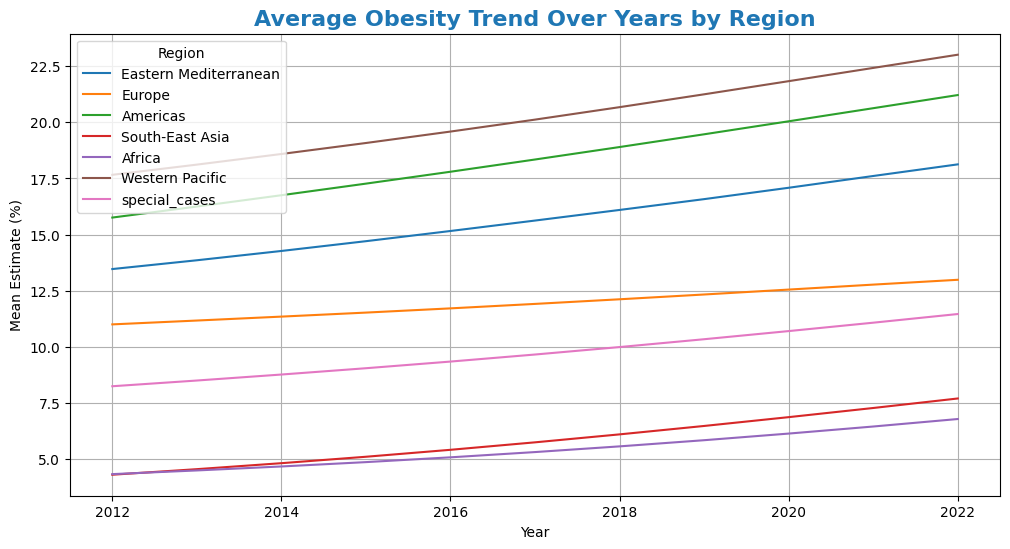

In [144]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_obesity, x='Year', y='Mean_Estimate', hue='Region', estimator='mean', ci=None)
plt.title(
    'Average Obesity Trend Over Years by Region',
    fontdict={
        'fontsize': 16,
        'fontweight': 'bold',
        'color': '#1f77b4',          # Customize the color
        'family': 'sans-serif'       # Other options: 'serif', 'monospace', 'cursive'
    }
)
plt.ylabel('Mean Estimate (%)')
plt.grid(True)
plt.show()

## 2. Bar Chart - Top 10 countries with highest average obesity:
📖 **Storyline: "Where Waistlines Widen — A Global Snapshot of Obesity Leaders"**

This bar chart isn’t just a ranking — it’s a wake-up call. It reveals the countries where obesity has become a dominant public health challenge, often tied to urbanization, processed food consumption, sedentary lifestyles, and socioeconomic shifts.

**By showcasing the top 10 countries with the highest average obesity rates, you’re inviting viewers to ask:**

*   🧠 What cultural or economic factors drive these numbers?
*   🏥 Are healthcare systems in these nations equipped to handle obesity-related diseases?
*   📉 Is there any sign of reversal, or are trends still climbing?







In [181]:
top10_obesity = (
    df_obesity.groupby('Country')['Mean_Estimate']
    .mean()
    .nlargest(10)
    .sort_values()
    .reset_index()
)

/tmp/ipython-input-2415687823.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')
/tmp/ipython-input-2415687823.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


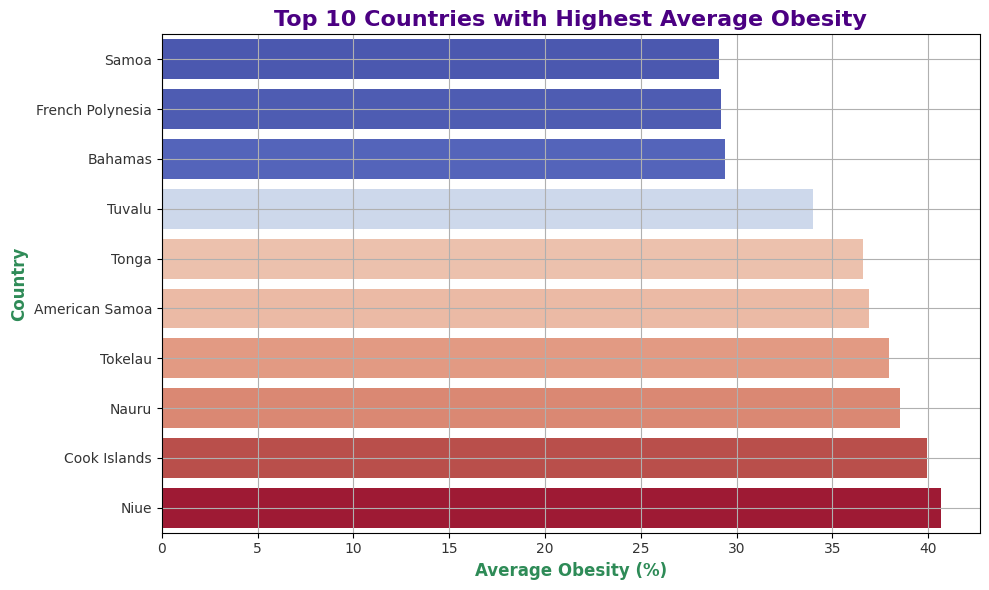

In [158]:
# Normalize the data to map values to colors
norm = mcolors.Normalize(vmin=top10_obesity['Mean_Estimate'].min(),
                         vmax=top10_obesity['Mean_Estimate'].max())

# Choose a colormap (try 'viridis', 'plasma', 'inferno', 'coolwarm')
cmap = cm.get_cmap('coolwarm')

# Map each value to a color
colors = [cmap(norm(value)) for value in top10_obesity['Mean_Estimate']]

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=top10_obesity,
    x='Mean_Estimate',
    y='Country',
    palette=colors
)

# Stylish title and labels
plt.title(
    'Top 10 Countries with Highest Average Obesity',
    fontdict={'fontsize': 16, 'fontweight': 'bold', 'color': '#4B0082'}
)
plt.xlabel('Average Obesity (%)', fontsize=12, color='#2E8B57', fontweight='bold')
plt.ylabel('Country', fontsize=12, color='#2E8B57', fontweight='bold')
plt.xticks(color='#333333', fontsize=10)
plt.yticks(color='#333333', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


## 3."Malnutrition’s Gender Divide"
📖 **Storyline: "Unboxing Inequality — A Gendered Glimpse into Malnutrition"**
This visualization invites us to explore not just average malnutrition rates, but the distribution and variability between genders. The boxplot reveals how one gender might experience wider disparities — suggesting greater vulnerability or systemic gaps in nutrition access.

/tmp/ipython-input-3850053737.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_malnutrition, x='Gender', y='Mean_Estimate',


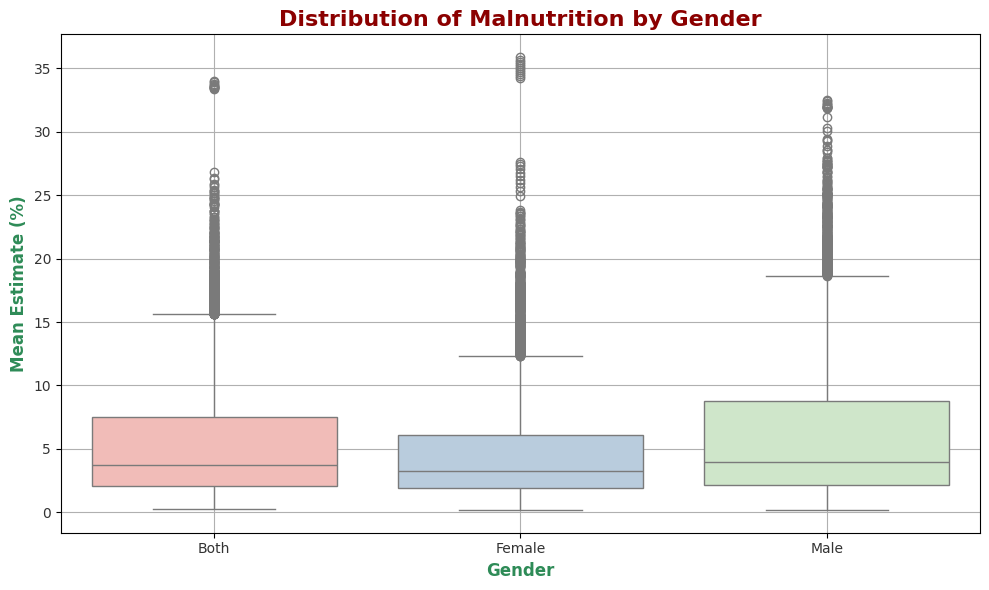

In [164]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_malnutrition, x='Gender', y='Mean_Estimate',
            palette='Pastel1')  # Use palette='set2' or palette='Set1' or palette='Dark2'
# These palette are best for Categorical data with distinct groups
# Title styling
plt.title(
    'Distribution of Malnutrition by Gender',
    fontdict={
        'fontsize': 16,
        'fontweight': 'bold',
        'color': '#8B0000',       # Dark red for emphasis
        'family': 'sans-serif'
    }
)

# Label styling
plt.ylabel('Mean Estimate (%)', fontsize=12, color='#2E8B57', fontweight='bold')
plt.xlabel('Gender', fontsize=12, color='#2E8B57', fontweight='bold')

# Tick label styling
plt.xticks(color='#333333', fontsize=10)
plt.yticks(color='#333333', fontsize=10)

plt.grid(True)
plt.tight_layout()
plt.show()


## 4.Top 10 Countries by Obesity (Bar Chart)
🍔📊 **Story Title: "Global Heavyweights — Top 10 Countries by Obesity"**

This isn’t just a leaderboard — it’s a call to action. By spotlighting the top contributors to global obesity, the chart invites questions about lifestyle, culture, healthcare, and policy. Why do these nations top the list? Is it fast food, urbanization, genetics, or something else?

In [180]:
top_obese = df_obesity.groupby('Country')['Mean_Estimate'].mean().nlargest(10).reset_index()

/tmp/ipython-input-2163010661.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')
/tmp/ipython-input-2163010661.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_obese, x='Mean_Estimate', y='Country', palette=colors)


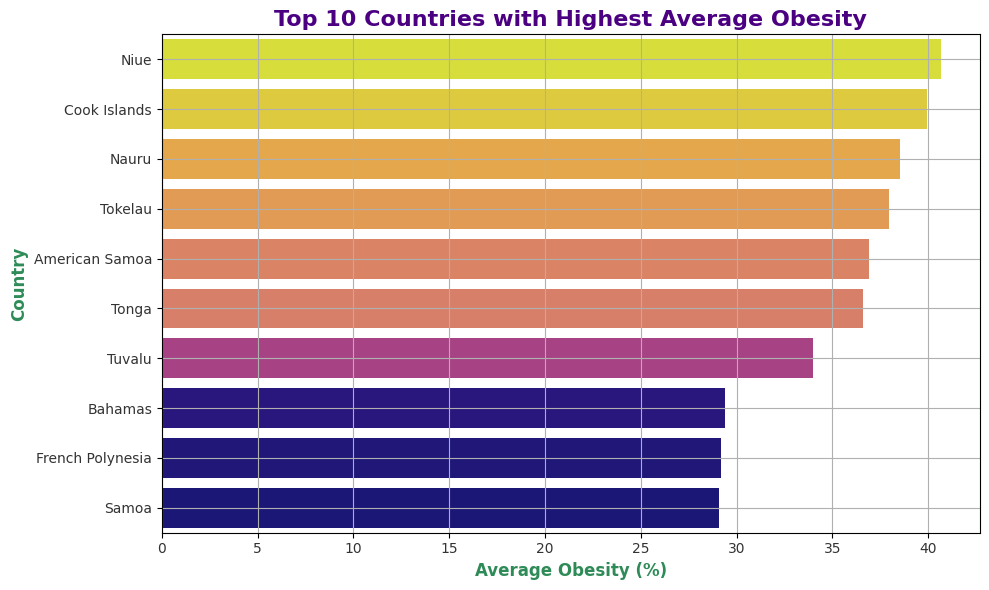

In [166]:
# Normalize values for gradient mapping
norm = mcolors.Normalize(vmin=top_obese['Mean_Estimate'].min(),
                         vmax=top_obese['Mean_Estimate'].max())

# Get colors from the 'plasma' colormap
cmap = cm.get_cmap('plasma')
colors = [cmap(norm(value)) for value in top_obese['Mean_Estimate']]

# Plot with custom gradient
plt.figure(figsize=(10,6))
sns.barplot(data=top_obese, x='Mean_Estimate', y='Country', palette=colors)

# Title styling
plt.title(
    'Top 10 Countries with Highest Average Obesity',
    fontdict={'fontsize': 16, 'fontweight': 'bold', 'color': '#4B0082'}
)

# Axis label styling
plt.xlabel('Average Obesity (%)', fontsize=12, color='#2E8B57', fontweight='bold')
plt.ylabel('Country', fontsize=12, color='#2E8B57', fontweight='bold')

# Tick styling
plt.xticks(color='#333333', fontsize=10)
plt.yticks(color='#333333', fontsize=10)

plt.grid(True)
plt.tight_layout()
plt.show()


## 5. Malnutrition by Region and Year (Heatmap):
.
🍂 **Story Title: "Uneven Hunger — Tracing Malnutrition Across Regions and Time"**

Picture this: A child in Region A grows up with nutritional support, while one in Region B struggles year after year. This heatmap isn’t just data — it’s a revelation of how opportunity and hardship are geographically etched.

With the Region–Year matrix you built, the heatmap can:

🔥 **Highlight High-Burden**: Where malnutrition is persistently high, even as the years change.

🧊 **Reveal Success Stories**: Regions that show consistent decline — perhaps thanks to policy reforms or community action.

🕰️ **Detect Shifting Vulnerabilities**: A region low-risk in 2000 might be high-risk in 2020. Why?

In [167]:

heat_data = df_malnutrition.pivot_table(index='Region', columns='Year', values='Mean_Estimate', aggfunc='mean')

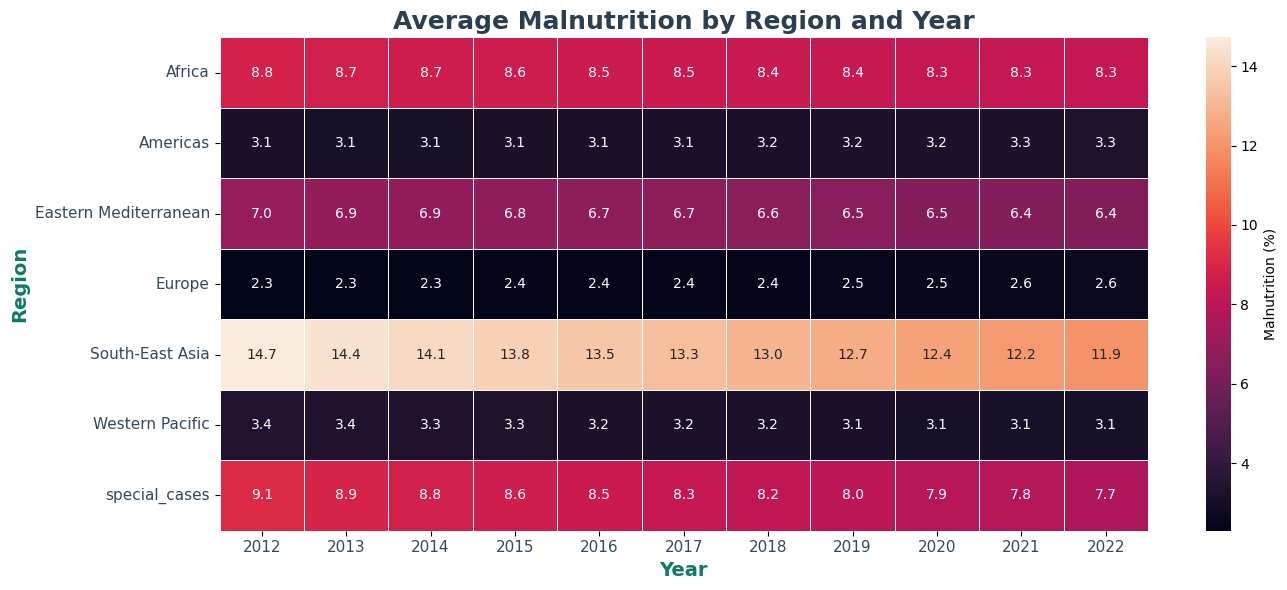

In [171]:
plt.figure(figsize=(14,6))
sns.heatmap(heat_data, annot=True, cmap='rocket', fmt='.1f',
            linewidths=0.5, linecolor='white', cbar_kws={'label': 'Malnutrition (%)'})

# Title styling
plt.title('Average Malnutrition by Region and Year',
          fontdict={'fontsize': 18, 'fontweight': 'bold', 'color': '#2C3E50'})

# Axis label styling
plt.ylabel('Region', fontsize=14, color='#117A65', fontweight='bold')
plt.xlabel('Year', fontsize=14, color='#117A65', fontweight='bold')

# Tick label styling
plt.xticks(color='#34495E', fontsize=11)
plt.yticks(color='#34495E', fontsize=11)

plt.tight_layout()
plt.show()

## 6.Pivot the data to create a Region vs Year matrix
🌍📆 **Story Title: "Mapping the Momentum — Regional Shifts in Nutrition Over Time"**
Imagine italicised text you’re tasked with tracking how different regions battle obesity or malnutrition across years. By pivoting the data into a Region vs Year matrix, you transform raw trends into a comparative landscape — exposing who surged ahead, who stagnated, and where interventions might be urgently needed.
This matrix sets the stage for:

📈 **Heatmaps**: Visual intensity that spotlights sudden spikes or dips.

🎞️ **Animations**: Watch how regional health burdens ebb and flow with time.

🧭 **Policy Mapping**: Use the matrix to align with government action or funding waves.

In [179]:
heatmap_data = df_obesity.pivot_table(index='Region', columns='Year', values='Mean_Estimate', aggfunc='mean')

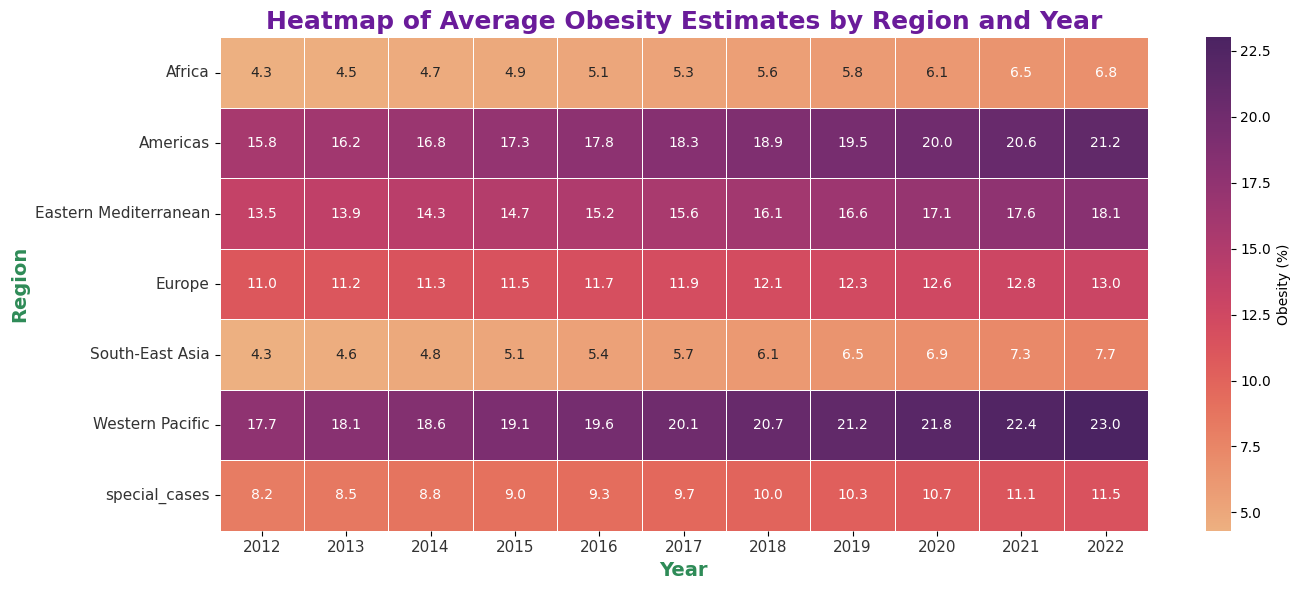

In [173]:
plt.figure(figsize=(14,6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="flare",
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Obesity (%)'}
)

# Title styling
plt.title(
    'Heatmap of Average Obesity Estimates by Region and Year',
    fontdict={'fontsize': 18, 'fontweight': 'bold', 'color': '#6A1B9A'}
)

# Axis label styling
plt.ylabel('Region', fontsize=14, color='#2E8B57', fontweight='bold')
plt.xlabel('Year', fontsize=14, color='#2E8B57', fontweight='bold')

# Tick labels
plt.xticks(color='#333333', fontsize=11)
plt.yticks(color='#333333', fontsize=11)

plt.tight_layout()
plt.show()


## 📊 7. Gender Gap in Obesity Over Time
**Story: How has the gap between male and female obesity prevalence evolved? Are trends converging or diverging?**

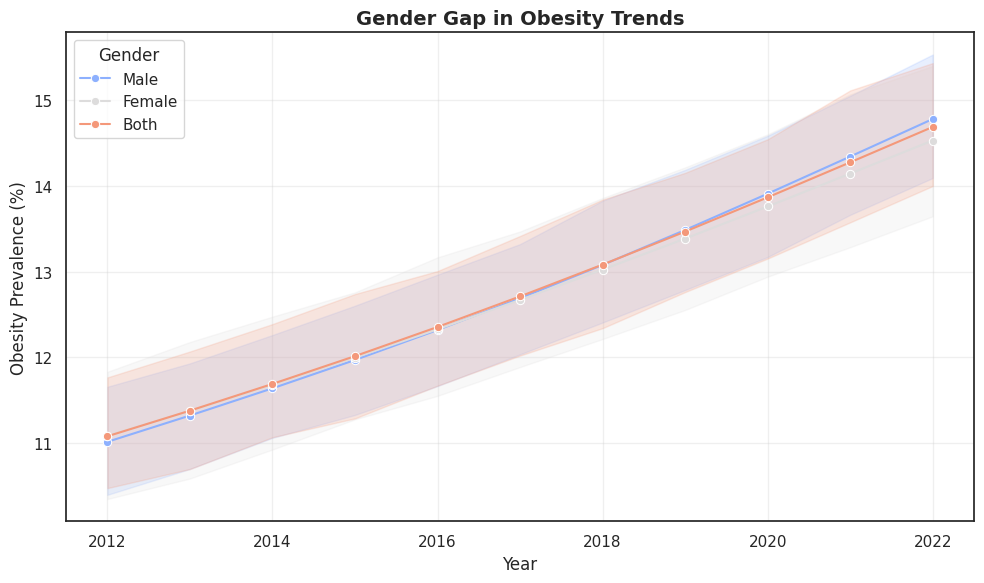

In [176]:
sns.set_theme(style="white", palette="Set2")

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_obesity,
    x="Year", y="Mean_Estimate", hue="Gender",
    estimator="mean", marker="o", palette="coolwarm"
)
plt.title("Gender Gap in Obesity Trends", fontsize=14, weight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Obesity Prevalence (%)", fontsize=12)
plt.legend(title="Gender")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 🍽️ 8. Intersecting Trends of Obesity vs. Malnutrition
**Story: Despite being opposite ends of the nutritional spectrum, can obesity and malnutrition coexist within the same regions or demographics over time?**

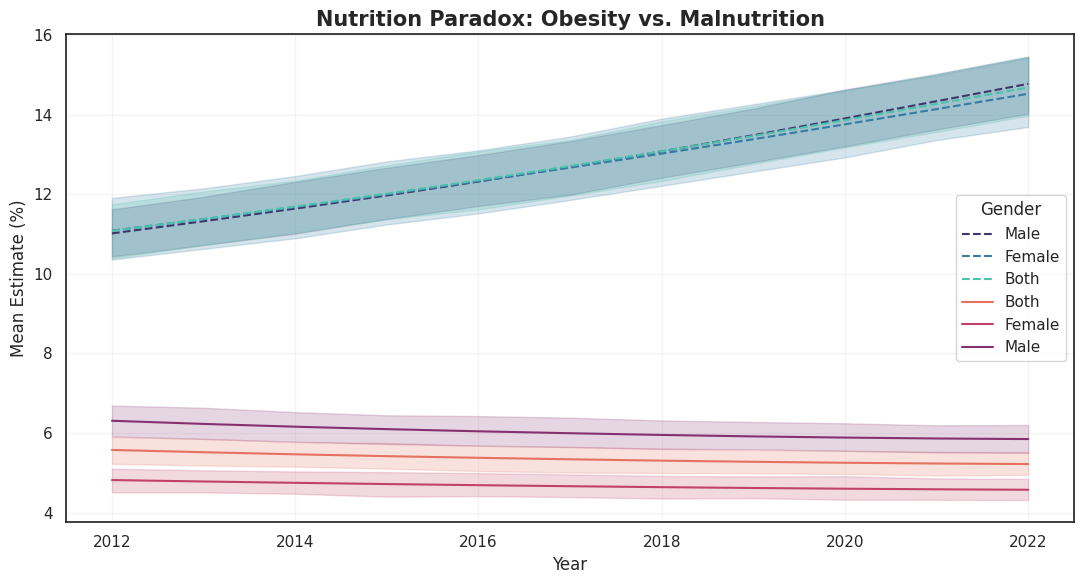

In [178]:
fig, ax = plt.subplots(figsize=(11, 6))

# Obesity Line
sns.lineplot(
    data=df_obesity,
    x="Year", y="Mean_Estimate", hue="Gender",
    estimator="mean", linestyle="--", palette="mako", ax=ax
)

# Malnutrition Line
sns.lineplot(
    data=df_malnutrition,
    x="Year", y="Mean_Estimate", hue="Gender",
    estimator="mean", palette="flare", ax=ax
)

plt.title("Nutrition Paradox: Obesity vs. Malnutrition", fontsize=15, weight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Mean Estimate (%)", fontsize=12)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


# **Step 4: MySQL Database Setup**

In [63]:
pip install mysql-connector-python streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.2 MB/s eta 0:00:00


In [64]:
import mysql.connector  # For MySQL database operations
from mysql.connector import Error
import pandas as pd  # For data manipulation and analysis
import streamlit as st  # For building the interactive web app
from datetime import datetime, timedelta  # For handling dates and times
import sys


In [65]:

# Database configuration
db_config = {
    'host': 'gateway01.ap-southeast-1.prod.aws.tidbcloud.com',
    'port': '4000',
    'user': '2yAFaedwBArCDSP.root',
    'password': 'OKWXUUFbHCuz3Oct',
}

# Connect to MySQL
conn = mysql.connector.connect(**db_config)
cur = conn.cursor()
print("Connected to MySQL!")

Connected to MySQL!


In [66]:
cur.execute("CREATE DATABASE IF NOT EXISTS Nutrition_Paradox")
cur.execute("USE Nutrition_Paradox")

In [ ]:
 # Create obesity table
cur.execute("""
        CREATE TABLE IF NOT EXISTS obesity (
            id INT AUTO_INCREMENT PRIMARY KEY,
            Year INT NOT NULL,
            Gender VARCHAR(10) NOT NULL,
            Mean_Estimate DECIMAL(5,2) NOT NULL,
            LowerBound DECIMAL(5,2),
            UpperBound DECIMAL(5,2),
            Age_Group VARCHAR(20) NOT NULL,
            Country VARCHAR(100) NOT NULL,
            Region VARCHAR(100),
            CI_Width DECIMAL(5,2) GENERATED ALWAYS AS (UpperBound - LowerBound) STORED,
            Obesity_Level VARCHAR(20),
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
            INDEX idx_country (Country),
            INDEX idx_year (Year),
            INDEX idx_region (Region)
        )
        """)
conn.commit()
print("obesity table created!")

obesity table created!


In [ ]:
 # Create malnutrition table
cur.execute("""
        CREATE TABLE IF NOT EXISTS malnutrition (
            id INT AUTO_INCREMENT PRIMARY KEY,
            Year INT NOT NULL,
            Gender VARCHAR(10) NOT NULL,
            Mean_Estimate DECIMAL(5,2) NOT NULL,
            LowerBound DECIMAL(5,2),
            UpperBound DECIMAL(5,2),
            Age_Group VARCHAR(20) NOT NULL,
            Country VARCHAR(100) NOT NULL,
            Region VARCHAR(100),
            CI_Width DECIMAL(5,2) GENERATED ALWAYS AS (UpperBound - LowerBound) STORED,
            Malnutrition_Level VARCHAR(20),
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
            INDEX idx_country (Country),
            INDEX idx_year (Year),
            INDEX idx_region (Region)
        )
        """)
conn.commit()
print("malnutrition table created!")

malnutrition table created!


In [ ]:
print(df_obesity.shape)
print(df_malnutrition.shape)

(27720, 10)
(27720, 10)


In [ ]:
def insert_data_iterrows(df, table_name, conn, cur):
    """
    Inserts data row-by-row into MySQL using iterrows, skipping auto/computed columns.
    """
    print(f"Inserting into {table_name}...")

    # Columns to exclude from manual insert
    excluded = ['id', 'CI_Width', 'created_at']
    columns = [col for col in df.columns if col not in excluded]

    column_names = ', '.join(columns)
    placeholders = ', '.join(['%s'] * len(columns))
    insert_query = f"INSERT INTO {table_name} ({column_names}) VALUES ({placeholders})"

    inserted = 0
    for idx, row in df.iterrows():
        try:
            values = tuple(row[col] for col in columns)
            cur.execute(insert_query, values)
            inserted += 1

            # Optional progress logging
            if inserted % 10000 == 0:
                print(f"{inserted} rows inserted into {table_name}...")
        except Exception as e:
            print(f"⚠️ Row {idx} failed: {e}")
            continue

    conn.commit()
    print(f"✅ Inserted {inserted} rows into '{table_name}'")

In [ ]:
insert_data_iterrows(df_obesity, 'obesity', conn, cur)
insert_data_iterrows(df_malnutrition, 'malnutrition', conn, cur)


Inserting into obesity...
10000 rows inserted into obesity...
20000 rows inserted into obesity...
✅ Inserted 27720 rows into 'obesity'
Inserting into malnutrition...
10000 rows inserted into malnutrition...
20000 rows inserted into malnutrition...
✅ Inserted 27720 rows into 'malnutrition'


In [67]:
cur.execute("SELECT * FROM obesity")
data = cur.fetchall()
#fetches the names of your columns in dataframe(cursor.description holds the columns info)
columns = [i[0] for i in cur.description]


In [68]:
import pandas as pd
# using the result fetched in cursor, create a new dataframe
df_obesity_sql = pd.DataFrame(data,columns=columns)
df_obesity_sql

,id,Year,Gender,Mean_Estimate,LowerBound,UpperBound,Age_Group,Country,Region,CI_Width,Obesity_Level,created_at
0,30001,2020,Male,25.50,23.10,27.90,Adults,India,South Asia,4.80,Moderate,2025-07-28 18:48:06
1,30002,2021,Female,30.20,28.50,31.80,Adults,India,South Asia,3.30,High,2025-07-28 18:48:06
2,60001,2020,Male,17.49,15.79,19.25,Adult,"Iran, Islamic Republic of",Eastern Mediterranean,3.46,Low,2025-07-29 17:07:58
3,60002,2020,Male,28.34,23.09,33.82,Adult,Iraq,Eastern Mediterranean,10.73,Moderate,2025-07-29 17:07:58
4,60003,2014,Female,27.95,24.92,31.21,Adult,Greenland,Europe,6.29,Moderate,2025-07-29 17:07:58
...,...,...,...,...,...,...,...,...,...,...,...,...
35021,95020,2020,Both,1.48,0.96,2.20,Child/Adolescent,Tajikistan,Europe,1.24,Low,2025-07-29 17:57:53
35022,95021,2012,Female,1.97,0.30,5.87,Child/Adolescent,Somalia,Eastern Mediterranean,5.57,Low,2025-07-29 17:57:53
35023,95022,2021,Male,16.63,3.33,34.88,Child/Adolescent,Vanuatu,Western Pacific,31.55,Low,2025-07-29 17:57:54
35024,95023,2014,Male,2.03,0.24,6.34,Child/Adolescent,Madagascar,Africa,6.10,Low,2025-07-29 17:57:54


In [69]:
df_obesity_sql.to_csv('final_obesity.csv', index=False)

In [70]:
cur.execute("SELECT * FROM malnutrition")
data = cur.fetchall()

#fetches the names of your columns in dataframe(cursor.description holds the columns info)
columns1 = [i[0] for i in cur.description]

In [71]:
import pandas as pd
# using the result fetched in cursor, create a new dataframe
df_malnutrition_sql = pd.DataFrame(data,columns=columns1)

df_malnutrition_sql

,id,Year,Gender,Mean_Estimate,LowerBound,UpperBound,Age_Group,Country,Region,CI_Width,Malnutrition_Level,created_at
0,1,2020,Male,15.50,13.10,17.90,Children,India,South Asia,4.80,Moderate,2025-07-28 18:48:06
1,2,2021,Female,18.20,16.50,19.80,Children,India,South Asia,3.30,High,2025-07-28 18:48:06
2,30001,2021,Female,5.80,3.97,8.08,Adult,Gabon,Africa,4.11,Low,2025-07-29 17:57:57
3,30002,2017,Both,3.09,2.43,3.84,Adult,Mongolia,Western Pacific,1.41,Low,2025-07-29 17:57:57
4,30003,2016,Female,8.37,6.66,10.25,Adult,Sierra Leone,Africa,3.59,Low,2025-07-29 17:57:57
...,...,...,...,...,...,...,...,...,...,...,...,...
27717,57716,2013,Female,4.14,2.80,5.71,Child/Adolescent,Haiti,Americas,2.91,Low,2025-07-29 18:38:05
27718,57717,2018,Both,7.57,5.43,10.22,Child/Adolescent,Tajikistan,Europe,4.79,Low,2025-07-29 18:38:05
27719,57718,2016,Both,1.70,0.62,3.51,Child/Adolescent,Papua New Guinea,Western Pacific,2.89,Low,2025-07-29 18:38:05
27720,57719,2020,Female,0.73,0.06,2.81,Child/Adolescent,Samoa,Western Pacific,2.75,Low,2025-07-29 18:38:05


In [72]:
df_malnutrition_sql.to_csv('final_malnutrition.csv', index=False)

# **Step 5 : SQL QUERIES**

## **🧋 Obesity Table (10 Queries)**

📊 1. Top 5 regions with the highest average obesity levels (2022)

In [86]:
# Database configuration
db_config = {
    'host': 'gateway01.ap-southeast-1.prod.aws.tidbcloud.com',
    'port': '4000',
    'user': '2yAFaedwBArCDSP.root',
    'password': 'OKWXUUFbHCuz3Oct',
}

# Connect to MySQL
conn = mysql.connector.connect(**db_config)
cur = conn.cursor()
print("Connected to MySQL!")

cur.execute("CREATE DATABASE IF NOT EXISTS Nutrition_Paradox")
cur.execute("USE Nutrition_Paradox")

Connected to MySQL!


In [83]:
results = cur.fetchall()

In [84]:
def run_query(query):
    cur.execute(query)
    return cur.fetchall()

In [97]:
query1 =("""
    SELECT region, AVG(mean_estimate) AS avg_obesity
    FROM obesity
    WHERE year = 2022
    GROUP BY region
    ORDER BY avg_obesity DESC
    LIMIT 5
""")
show_query(query1)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,region,avg_obesity
0,Western Pacific,25.433846
1,Americas,23.306988
2,Eastern Mediterranean,20.283904
3,Europe,15.354045
4,special_cases,12.664880


🌍 2. Top 5 countries with highest obesity estimates

In [98]:
query2 =("""
SELECT Country, MAX(Mean_estimate) AS peak_obesity
FROM obesity
GROUP BY Country
ORDER BY peak_obesity DESC
LIMIT 5;
""")
show_query(query2)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Country,peak_obesity
0,American Samoa,80.61
1,Tonga,79.05
2,Samoa,72.62
3,Tokelau,72.49
4,Cook Islands,71.51


🇮🇳 3. Obesity trend in India over the years

In [100]:
query3 =("""
SELECT Year, AVG(Mean_estimate) AS avg_obesity
FROM obesity
WHERE Country = 'India'
GROUP BY Year
ORDER BY Year;
""")
show_query(query3)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Year,avg_obesity
0,2012,2.776000
1,2013,2.957333
2,2014,3.142000
3,2015,3.357647
4,2016,3.550000
5,2017,3.776000
6,2018,3.974375
7,2019,4.180625
8,2020,5.845625
9,2021,6.403125



🚻 4. Average obesity by gender

In [101]:
query4 =("""
SELECT Gender, AVG(Mean_estimate) AS avg_obesity
FROM obesity
GROUP BY Gender;
""")
show_query(query4)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Gender,avg_obesity
0,Both,14.542016
1,Female,15.205388
2,Male,13.814760


👶👵 5. Country count by obesity level category and age group

In [105]:
query5 =("""
SELECT Obesity_Level, Age_group, COUNT(DISTINCT Country) AS country_count
FROM obesity
GROUP BY Obesity_Level, Age_group;
""")
show_query(query5)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Obesity_Level,Age_group,country_count
0,Moderate,Adults,1
1,High,Adults,1
2,Low,Adult,176
3,Moderate,Adult,99
4,High,Adult,94
5,Low,Child/Adolescent,210
6,High,Child/Adolescent,11
7,Moderate,Child/Adolescent,26


⚠️ 6. Reliability via CI_Width (Top 5 highest/lowest)

In [107]:
# Most and Least Reliable Countries (CI_Width)

In [112]:
query6 =("""
SELECT Country, AVG(CI_Width) AS avg_ci
FROM obesity
GROUP BY Country
ORDER BY avg_ci DESC
LIMIT 5;
""")
show_query(query6)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Country,avg_ci
0,Bermuda,24.232695
1,Antigua and Barbuda,22.129096
2,American Samoa,21.077455
3,Puerto Rico,19.924970
4,Grenada,19.359231


In [108]:
# Most consistent: lowest average CI_Width

In [111]:
query6a =("""
SELECT Country, AVG(CI_Width) AS avg_ci
FROM obesity
GROUP BY Country
ORDER BY avg_ci ASC
LIMIT 5;
""")
show_query(query6a)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Country,avg_ci
0,Global,0.680000
1,Low & Middle Income,0.826506
2,South-East Asia Region,0.985542
3,Japan,1.148072
4,India,1.152573


🎂 7. Average obesity by age group

In [113]:
query7 =("""
SELECT Age_group, AVG(Mean_estimate) AS avg_obesity
FROM obesity
GROUP BY Age_group;
""")
show_query(query7)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Age_group,avg_obesity
0,Adults,27.85000
1,Adult,21.83324
2,Child/Adolescent,9.73044


🟢 8. Consistently low-obesity countries

In [114]:
query8 =("""
SELECT Country, AVG(Mean_estimate) AS avg_obesity, AVG(CI_Width) AS avg_ci
FROM obesity
GROUP BY Country
HAVING avg_obesity < 10 AND avg_ci < 2
ORDER BY avg_obesity ASC, avg_ci ASC
LIMIT 10;
""")
show_query(query8)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Country,avg_obesity,avg_ci
0,Timor-Leste,1.104464,1.222798
1,Ethiopia,1.538869,1.436726
2,Burkina Faso,2.260359,1.540359
3,Bangladesh,2.330364,1.550424
4,Japan,4.060181,1.148072
5,India,4.112573,1.152573
6,South-East Asia Region,4.628434,0.985542
7,Low Income,4.876325,1.741687
8,Africa,5.538443,1.311976
9,Low & Middle Income,6.428795,0.826506


👩‍⚕️👨‍⚕️ 9. Countries where female obesity exceeds male by large margin

In [115]:
query9 =("""
SELECT f.Country, f.Year, f.Mean_estimate - m.Mean_estimate AS diff
FROM obesity f
JOIN obesity m ON f.Country = m.Country AND f.Year = m.Year
WHERE f.Gender = 'Female' AND m.Gender = 'Male'
AND f.Mean_estimate - m.Mean_estimate > 10
ORDER BY diff DESC;""")
show_query(query9)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Country,Year,diff
0,American Samoa,2012,53.25
1,American Samoa,2012,53.25
2,American Samoa,2012,53.11
3,American Samoa,2012,53.11
4,American Samoa,2012,52.86
...,...,...,...
11878,Montenegro,2019,10.01
11879,Vanuatu,2016,10.01
11880,Oman,2015,10.01
11881,Oman,2015,10.01


🌐 10. Global average obesity percentage per year

In [116]:
query10 =("""
SELECT Year, AVG(Mean_estimate) AS global_avg
FROM obesity
GROUP BY Year
ORDER BY Year;
""")
show_query(query10)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Year,global_avg
0,2012,12.711424
1,2013,13.044139
2,2014,13.384412
3,2015,13.703189
4,2016,14.081144
5,2017,14.441673
6,2018,14.842616
7,2019,15.242091
8,2020,15.668562
9,2021,16.105783


## **🧪 Malnutrition SQL Queries**

In [118]:
# Database configuration
db_config = {
    'host': 'gateway01.ap-southeast-1.prod.aws.tidbcloud.com',
    'port': '4000',
    'user': '2yAFaedwBArCDSP.root',
    'password': 'OKWXUUFbHCuz3Oct',
}

# Connect to MySQL
conn = mysql.connector.connect(**db_config)
cur = conn.cursor()
print("Connected to MySQL!")

cur.execute("CREATE DATABASE IF NOT EXISTS Nutrition_Paradox")
cur.execute("USE Nutrition_Paradox")

Connected to MySQL!


Avg. malnutrition by age group – 🧒📊

In [119]:
querym1 =("""
SELECT Age_Group, AVG(Mean_Estimate) AS Avg_Malnutrition
FROM Malnutrition
GROUP BY Age_Group;
""")
show_query(querym1)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Age_Group,Avg_Malnutrition
0,Children,16.850000
1,Child/Adolescent,5.159055
2,Adult,5.940596


Top 5 countries with highest malnutrition – 🌍🔥

In [120]:
querym2 = ("""
SELECT Country, AVG(Mean_Estimate) AS Avg_Malnutrition
FROM Malnutrition
GROUP BY Country
ORDER BY Avg_Malnutrition DESC
LIMIT 5;
""")
show_query(querym2)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Country,Avg_Malnutrition
0,India,22.063433
1,South-East Asia Region,19.239091
2,Bangladesh,18.245909
3,Sri Lanka,17.871742
4,Eritrea,17.472879


Malnutrition trend in African region over the years – 🌍📈

In [121]:
querym3 = ("""
SELECT Year, AVG(Mean_Estimate) AS African_Trend
FROM Malnutrition
WHERE Region = 'Africa'
GROUP BY Year
ORDER BY Year;
""")
show_query(querym3)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Year,African_Trend
0,2012,8.849645
1,2013,8.749823
2,2014,8.663103
3,2015,8.587553
4,2016,8.522961
5,2017,8.466489
6,2018,8.414645
7,2019,8.369663
8,2020,8.331348
9,2021,8.298422


In [122]:
querym4 = ("""
SELECT Gender, AVG(Mean_Estimate) AS Avg_Malnutrition
FROM Malnutrition
GROUP BY Gender;
""")
show_query(querym4)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Gender,Avg_Malnutrition
0,Female,4.676906
1,Male,6.027331
2,Both,5.361573


In [123]:
querym5 = ("""
SELECT Age_Group, AVG(CI_Width) AS Avg_CI_Width
FROM Malnutrition
GROUP BY Age_Group;
""")
show_query(querym5)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Age_Group,Avg_CI_Width
0,Adult,3.693847
1,Child/Adolescent,5.103122
2,Children,4.050000


In [124]:
querym6 = ("""
SELECT Country, Year, AVG(Mean_Estimate) AS Avg_Malnutrition
FROM Malnutrition
WHERE Country IN ('India', 'Nigeria', 'Brazil')
GROUP BY Country, Year
ORDER BY Country, Year;
""")
show_query(querym6)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Country,Year,Avg_Malnutrition
0,Brazil,2012,2.840000
1,Brazil,2013,2.781667
2,Brazil,2014,2.734167
3,Brazil,2015,2.698333
4,Brazil,2016,2.672500
5,Brazil,2017,2.654167
6,Brazil,2018,2.641667
7,Brazil,2019,2.635000
8,Brazil,2020,2.629167
9,Brazil,2021,2.628333


In [ ]:
querym3 = ("""

""")
show_query(querym3)

In [125]:
querym7 = ("""
SELECT Region, AVG(Mean_Estimate) AS Avg_Malnutrition
FROM Malnutrition
GROUP BY Region
ORDER BY Avg_Malnutrition ASC
LIMIT 5;
""")
show_query(querym7)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Region,Avg_Malnutrition
0,Europe,2.426808
1,Americas,3.174705
2,Western Pacific,3.220462
3,Eastern Mediterranean,6.661371
4,special_cases,8.354077


In [126]:
querym8 = ("""
SELECT Country, MAX(Mean_Estimate) - MIN(Mean_Estimate) AS Increase
FROM Malnutrition
GROUP BY Country
HAVING Increase > 0
ORDER BY Increase DESC;
""")
show_query(querym8)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Country,Increase
0,Eritrea,28.02
1,Ethiopia,21.75
2,Somalia,20.83
3,India,18.83
4,Pakistan,17.74
...,...,...
205,Cook Islands,1.19
206,Peru,1.16
207,Niue,0.90
208,American Samoa,0.90


In [127]:
querym9 = ("""
SELECT Year,
       MIN(Mean_Estimate) AS Min_Malnutrition,
       MAX(Mean_Estimate) AS Max_Malnutrition
FROM Malnutrition
GROUP BY Year
ORDER BY Year;
""")
show_query(querym9)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Year,Min_Malnutrition,Max_Malnutrition
0,2012,0.18,35.89
1,2013,0.18,35.69
2,2014,0.18,35.50
3,2015,0.18,35.31
4,2016,0.18,35.15
5,2017,0.18,35.00
6,2018,0.18,34.86
7,2019,0.18,34.72
8,2020,0.18,34.58
9,2021,0.18,34.43


In [128]:
querym10 = ("""
SELECT Country, Year, Age_Group, Gender, CI_Width
FROM Malnutrition
WHERE CI_Width > 5
ORDER BY CI_Width DESC;
""")
show_query(querym10)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Country,Year,Age_Group,Gender,CI_Width
0,Senegal,2022,Child/Adolescent,Male,26.70
1,Senegal,2021,Child/Adolescent,Male,25.68
2,Senegal,2020,Child/Adolescent,Male,24.58
3,Mauritania,2022,Child/Adolescent,Male,23.82
4,Senegal,2019,Child/Adolescent,Male,23.47
...,...,...,...,...,...
9556,Dominica,2015,Child/Adolescent,Male,5.01
9557,Philippines,2022,Child/Adolescent,Both,5.01
9558,Botswana,2013,Adult,Female,5.01
9559,Côte d'Ivoire,2022,Child/Adolescent,Female,5.01


## **🔗 Combined (5 Queries)**

In [129]:
# Database configuration
db_config = {
    'host': 'gateway01.ap-southeast-1.prod.aws.tidbcloud.com',
    'port': '4000',
    'user': '2yAFaedwBArCDSP.root',
    'password': 'OKWXUUFbHCuz3Oct',
}

# Connect to MySQL
conn = mysql.connector.connect(**db_config)
cur = conn.cursor()
print("Connected to MySQL!")

cur.execute("CREATE DATABASE IF NOT EXISTS Nutrition_Paradox")
cur.execute("USE Nutrition_Paradox")

Connected to MySQL!


Obesity vs malnutrition comparison by country (any 5) – ⚖️🌎

In [130]:
queryC1 = ("""
SELECT o.Country,
       AVG(o.Mean_Estimate) AS Avg_Obesity,
       AVG(m.Mean_Estimate) AS Avg_Malnutrition
FROM Obesity o
JOIN Malnutrition m ON o.Country = m.Country AND o.Year = m.Year
WHERE o.Country IN ('India', 'USA', 'Brazil', 'Nigeria', 'Japan')
GROUP BY o.Country;
""")
show_query(queryC1)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Country,Avg_Obesity,Avg_Malnutrition
0,Nigeria,5.339822,11.891657
1,India,4.143464,22.039822
2,Brazil,18.024848,2.685530
3,Japan,4.060181,3.839503


Gender-based disparity in both obesity and malnutrition – ♀️♂️🔍

In [131]:
queryC2 = ("""
SELECT o.Gender,
       AVG(o.Mean_Estimate) AS Avg_Obesity,
       AVG(m.Mean_Estimate) AS Avg_Malnutrition
FROM Obesity o
JOIN Malnutrition m ON o.Gender = m.Gender AND o.Year = m.Year AND o.Country = m.Country
GROUP BY o.Gender;
""")
show_query(queryC2)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Gender,Avg_Obesity,Avg_Malnutrition
0,Male,13.813963,6.033344
1,Female,15.204655,4.678226
2,Both,14.542016,5.362076


Region-wise avg estimates side-by-side (Africa & America) – 🌍🔄🌎

In [132]:
queryC3 = ("""
SELECT o.Region,
       AVG(o.Mean_Estimate) AS Avg_Obesity,
       AVG(m.Mean_Estimate) AS Avg_Malnutrition
FROM Obesity o
JOIN Malnutrition m ON o.Region = m.Region AND o.Year = m.Year
WHERE o.Region IN ('Africa', 'America')
GROUP BY o.Region;
""")
show_query(queryC3)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Region,Avg_Obesity,Avg_Malnutrition
0,Africa,6.332651,8.501781


Countries with obesity up & malnutrition down – 📈⬆️📉⬇️

In [133]:
queryC4 = ("""
SELECT o.Country,
       MAX(o.Mean_Estimate) - MIN(o.Mean_Estimate) AS Obesity_Change,
       MIN(m.Mean_Estimate) - MAX(m.Mean_Estimate) AS Malnutrition_Change
FROM Obesity o
JOIN Malnutrition m ON o.Country = m.Country AND o.Year = m.Year
GROUP BY o.Country
HAVING Obesity_Change > 0 AND Malnutrition_Change > 0;
""")
show_query(queryC4)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Country,Obesity_Change,Malnutrition_Change


Age-wise trend analysis – 👶➡️👴📊

In [134]:
queryC5 = ("""
SELECT o.Age_Group, o.Year,
       AVG(o.Mean_Estimate) AS Avg_Obesity,
       AVG(m.Mean_Estimate) AS Avg_Malnutrition
FROM Obesity o
JOIN Malnutrition m ON o.Age_Group = m.Age_Group AND o.Year = m.Year
GROUP BY o.Age_Group, o.Year
ORDER BY o.Age_Group, o.Year;
""")
show_query(queryC5)

/tmp/ipython-input-3918258786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,Age_Group,Year,Avg_Obesity,Avg_Malnutrition
0,Adult,2012,19.517968,6.443619
1,Adult,2013,19.949349,6.320873
2,Adult,2014,20.391556,6.206556
3,Adult,2015,20.847095,6.099556
4,Adult,2016,21.315413,5.999444
5,Adult,2017,21.790254,5.906619
6,Adult,2018,22.269540,5.820825
7,Adult,2019,22.757270,5.741302
8,Adult,2020,23.262159,5.667762
9,Adult,2021,23.777222,5.599524


# 📊 **Step 5: Power BI Visualization**
**Tasks(Optional) Connect SQL database to Power BI, load both the obesity_data and malnutrition_data tables, and use them to develop an interactive dashboard.**